# Project 4: Differential Privacy
Author: James Bui

This notebook compares the runtimes of the computation of numbers using different privacy methods.

In [1]:
from phe import paillier
import random
import time
import numpy as np
import matplotlib.pyplot as plt

### Setting

Set the prime and bit lengths so that Shamir's secret sharing and Paillier have the same security level.

In [2]:
bits_length = 64

n_values = [2, 10, 100, 250, 500]

eps = 1.0

prime = 10523145075623912869  # 64-bit prime

num_runs = 20

# Generate unique random integers for each n
data = {
    n: random.sample(range(1, 2*n + 1), n)
    for n in n_values
}
    
true_averages = {n: np.mean(arr) for n, arr in data.items()}

In [3]:
def time_function(func, *args, **kwargs):
    """
    Measures the runtime of a function.

    Parameters:
        func: The function to run
        *args: Positional arguments to pass to func
        **kwargs: Keyword arguments to pass to func

    Returns:
        result: The return value of func
        runtime: Time taken in seconds
    """
    start_time = time.perf_counter()
    result = func(*args, **kwargs)
    end_time = time.perf_counter()
    runtime = end_time - start_time
    return result, runtime

In [4]:
def compute_mse(avg_results, true_means):
    """
    Compute Mean Squared Error (MSE) of averages for each n.
    
    Parameters
    avg_results : dict
        Dictionary mapping n -> array/list of computed averages (e.g., noisy means or sample means).
    true_means : dict
        Dictionary mapping n -> true mean for that n.
        
    Returns
    dict
        Mapping n -> MSE value.
    """
    mse_results = {}
    for n, estimates in avg_results.items():
        y_true = true_means[n]
        y_pred = np.array(estimates)
        mse_results[n] = np.mean((y_pred - y_true) ** 2)
    return mse_results


### No privacy protection

In [5]:
def average_with_no_protection(nums):
    return sum(nums) / len(nums)

In [6]:
no_protection_runtimes = []
no_protection_results = {}

for n in n_values:
    runtimes = []
    results = []

    for _ in range(num_runs):
        result, runtime = time_function(average_with_no_protection, data[n])
        runtimes.append(runtime)
        results.append(result)

    avg_runtime = np.mean(runtimes)
    no_protection_runtimes.append(avg_runtime)
    no_protection_results[n] = results

    print(f"n = {n}")
    print(f"  Average runtime: {avg_runtime:.6f} s")
    print(f"  Last result: {results}\n")

no_protection_accuracy = compute_mse(no_protection_results, true_averages)

print("Average runtimes of no privacy protection:", no_protection_runtimes)
print("Results of no privacy protection:", no_protection_results)
print("Accuracy of no privacy protection", no_protection_accuracy)


n = 2
  Average runtime: 0.000000 s
  Last result: [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]

n = 10
  Average runtime: 0.000000 s
  Last result: [11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1]

n = 100
  Average runtime: 0.000000 s
  Last result: [104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39]

n = 250
  Average runtime: 0.000001 s
  Last result: [243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964]

n = 500
  Average runtime: 0.000002 s
  Last result: [494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238, 494.238

### The additively homomorphic *Paillier* encryption scheme 

In [7]:
import numpy as np
from phe import paillier

def initialize_keys(bits_length=2048):
    public_key, private_key = paillier.generate_paillier_keypair(n_length=bits_length)
    return public_key, private_key

def encrypt_data(public_key, data):
    return [public_key.encrypt(x) for x in data]

def add_encrypted_data(encrypted_data):
    return sum(encrypted_data)

def decrypt_data(private_key, encrypted_sum):
    return private_key.decrypt(encrypted_sum)

def perform_encrypted_addition(public_key, private_key, nums):
    # Encrypt
    encrypted_values = encrypt_data(public_key, nums)
    
    # Add encrypted numbers
    encrypted_sum = add_encrypted_data(encrypted_values)
    
    # Decrypt sum
    decrypted_sum = decrypt_data(private_key, encrypted_sum)
    
    avg = decrypted_sum / len(nums)
    return avg

# --- Separate timing for encryption, computation, and decryption ---

paillier_enc_times = []
paillier_add_times = []
paillier_dec_times = []
paillier_results = {}

public_key, private_key = initialize_keys(bits_length=bits_length)

for n in n_values:
    enc_times, add_times, dec_times = [], [], []
    results = []

    for _ in range(num_runs):
        nums = data[n]

        # Encryption timing
        encrypted_values, enc_time = time_function(encrypt_data, public_key, nums)
        
        # Addition timing
        encrypted_sum, add_time = time_function(add_encrypted_data, encrypted_values)
        
        # Decryption timing
        decrypted_sum, dec_time = time_function(decrypt_data, private_key, encrypted_sum)
        
        avg = decrypted_sum / len(nums)
        results.append(avg)

        enc_times.append(enc_time)
        add_times.append(add_time)
        dec_times.append(dec_time)

    # Store average runtimes per step
    paillier_enc_times.append(np.mean(enc_times))
    paillier_add_times.append(np.mean(add_times))
    paillier_dec_times.append(np.mean(dec_times))
    paillier_results[n] = results

    print(f"n = {n}")
    print(f"  Avg encryption time: {np.mean(enc_times):.6f} s")
    print(f"  Avg addition time:   {np.mean(add_times):.6f} s")
    print(f"  Avg decryption time: {np.mean(dec_times):.6f} s")
    print(f"  Last result: {results}\n")

paillier_accuracy = compute_mse(paillier_results, true_averages)

print("Paillier encryption times:", paillier_enc_times)
print("Paillier addition times:", paillier_add_times)
print("Paillier decryption times:", paillier_dec_times)
print("Paillier results:", paillier_results)
print("Paillier accuracy:", paillier_accuracy)


n = 2
  Avg encryption time: 0.000041 s
  Avg addition time:   0.000007 s
  Avg decryption time: 0.000011 s
  Last result: [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]

n = 10
  Avg encryption time: 0.000170 s
  Avg addition time:   0.000011 s
  Avg decryption time: 0.000010 s
  Last result: [11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1]

n = 100
  Avg encryption time: 0.001577 s
  Avg addition time:   0.000065 s
  Avg decryption time: 0.000011 s
  Last result: [104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39]

n = 250
  Avg encryption time: 0.003862 s
  Avg addition time:   0.000152 s
  Avg decryption time: 0.000011 s
  Last result: [243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964,

### Shamir's secret sharing

In [ ]:
# Evaluate a polynomial at a given x modulo a prime
def evaluate_polynomial_mod(x, coefficients, prime):
    result = 0
    power = 1
    for coeff in coefficients:
        result = (result + coeff * power) % prime
        power = (power * x) % prime
    return result % prime

def evaluate_polynomial_mod(x, coefficients, prime):
    return sum((coeff * pow(x, i, prime)) % prime for i, coeff in enumerate(coefficients)) % prime

# Generate shares for a secret modulo prime
def generate_shares_mod(secret, num_shares, threshold, prime):
    coefficients = [secret] + [random.randint(0, prime - 1) for _ in range(threshold - 1)]
    shares = [(x, evaluate_polynomial_mod(x, coefficients, prime)) for x in range(1, num_shares + 1)]
    return shares

# Reconstruct secret from shares using Lagrange interpolation modulo prime
def reconstruct_secret_mod(x_points, y_points, prime):
    num_points = len(x_points)
    secret = 0
    for i in range(num_points):
        numerator = 1
        denominator = 1
        for j in range(num_points):
            if i != j:
                numerator = (numerator * (-x_points[j])) % prime
                denominator = (denominator * (x_points[i] - x_points[j])) % prime
        inv_denominator = pow(denominator, -1, prime)
        secret = (secret + y_points[i] * numerator * inv_denominator) % prime
    return secret

# Phase 1: Encryption (Share Generation)
def encryption_phase(secrets, num_shares, threshold, prime):
    num_secrets = len(secrets)
    
    # Generate shares for each secret
    all_shares = []
    for secret in secrets:
        shares = generate_shares_mod(secret, num_shares, threshold, prime)
        all_shares.append(shares)
    
    return all_shares

# Phase 2: Calculation (Share Aggregation)
def calculation_phase(all_shares, num_shares, num_secrets, prime):
    # Sum the shares for each party (point-wise)
    summed_shares = []
    for i in range(num_shares):
        x = all_shares[0][i][0]  # same x for all secrets
        y_sum = sum(all_shares[s][i][1] for s in range(num_secrets)) % prime
        summed_shares.append((x, y_sum))
    
    return summed_shares

# Phase 3: Decryption (Secret Reconstruction)
def decryption_phase(summed_shares, threshold, prime, num_secrets):
    # Reconstruct the sum of secrets using first `threshold` shares
    x_points = [summed_shares[i][0] for i in range(threshold)]
    y_points = [summed_shares[i][1] for i in range(threshold)]
    total_sum = reconstruct_secret_mod(x_points, y_points, prime)
    
    # Compute the average
    average = total_sum / num_secrets
    return average

# Compute the average of multiple secrets using Shamir's Secret Sharing
def shamir_secret_sharing(secrets, num_shares, threshold, prime):
    num_secrets = len(secrets)
    
    # Phase 1: Encryption
    all_shares, encryption_time = time_function(encryption_phase, secrets, num_shares, threshold, prime)
    
    # Phase 2: Calculation
    summed_shares, calculation_time = time_function(calculation_phase, all_shares, num_shares, num_secrets, prime)
    
    # Phase 3: Decryption
    average, decryption_time = time_function(decryption_phase, summed_shares, threshold, prime, num_secrets)
    
    return average, encryption_time, calculation_time, decryption_time


shamir_enc_times = []
shamir_calc_times = []
shamir_dec_times = []
shamir_results = {}

for n in n_values:
    enc_times, calc_times, dec_times = [], [], []
    results = []
    
    for _ in range(num_runs):
        nums = data[n]
        
        # Run Shamir Secret Sharing with timing
        avg, enc_time, calc_time, dec_time = shamir_secret_sharing(nums, n, n // 2 + 1, prime)
        
        results.append(avg)
        enc_times.append(enc_time)
        calc_times.append(calc_time)
        dec_times.append(dec_time)
    
    # Store average runtimes per step
    shamir_enc_times.append(np.mean(enc_times))
    shamir_calc_times.append(np.mean(calc_times))
    shamir_dec_times.append(np.mean(dec_times))
    shamir_results[n] = results
    
    print(f"n = {n}")
    print(f"  Avg encryption time:   {np.mean(enc_times):.6f} s")
    print(f"  Avg calculation time:  {np.mean(calc_times):.6f} s")
    print(f"  Avg decryption time:   {np.mean(dec_times):.6f} s")
    print(f"  Last result: {results}\n")

shamir_accuracy = compute_mse(shamir_results, true_averages)

print("Shamir encryption times:", shamir_enc_times)
print("Shamir calculation times:", shamir_calc_times)
print("Shamir decryption times:", shamir_dec_times)
print("Shamir results:", shamir_results)
print("Shamir accuracy:", shamir_accuracy)

n = 2
  Avg encryption time:   0.000005 s
  Avg calculation time:  0.000001 s
  Avg decryption time:   0.000002 s
  Last result: [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]

n = 10
  Avg encryption time:   0.000135 s
  Avg calculation time:  0.000008 s
  Avg decryption time:   0.000009 s
  Last result: [11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1, 11.1]

n = 100
  Avg encryption time:   0.175309 s
  Avg calculation time:  0.000509 s
  Avg decryption time:   0.000555 s
  Last result: [104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39, 104.39]

n = 250
  Avg encryption time:   3.727799 s
  Avg calculation time:  0.003842 s
  Avg decryption time:   0.003010 s
  Last result: [243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 243.964, 24

### Differential Privacy

In [9]:
def dp_average(nums, sensitivity, eps=1.0):
    average = np.mean(nums)
    noise = np.random.laplace(loc=0, scale=sensitivity / eps, size=1)
    return average + noise

In [10]:
dp_times = []
dp_results = {}

for n in n_values:
    run_times = []
    results = []

    nums = data[n]
    sensitivity = (2*n - 1) / n

    for _ in range(num_runs):
        avg, dp_time = time_function(dp_average, nums, sensitivity, eps)
        results.append(avg)
        run_times.append(dp_time)

    dp_times.append(np.mean(run_times))
    dp_results[n] = results

    print(f"n = {n}")
    print(f"  Avg DP computation time: {np.mean(run_times):.6f} s")
    print(f"  Last DP result: {results}\n")

dp_accuracy = compute_mse(dp_results, true_averages)

print("DP computation times:", dp_times)
print("DP results:", dp_results)
print("DP accuracy (MSE):", dp_accuracy)


n = 2
  Avg DP computation time: 0.000428 s
  Last DP result: [array([4.58331915]), array([2.92628679]), array([4.45710796]), array([2.25968051]), array([3.16227777]), array([5.99038758]), array([2.50069197]), array([3.62095217]), array([2.67739524]), array([2.54428069]), array([3.10344152]), array([10.83392093]), array([2.98737973]), array([2.05587119]), array([4.37825226]), array([6.85592398]), array([1.52064754]), array([2.29090591]), array([3.82442007]), array([3.4054122])]

n = 10
  Avg DP computation time: 0.000007 s
  Last DP result: [array([10.87796339]), array([14.65414386]), array([10.91142574]), array([10.08755]), array([9.50141937]), array([10.6488377]), array([9.7699077]), array([13.67973754]), array([9.633014]), array([10.17563528]), array([9.10511311]), array([11.45227902]), array([7.33447632]), array([11.55700024]), array([10.01817788]), array([12.84054028]), array([9.07114787]), array([13.83163178]), array([15.3708028]), array([6.0286604])]

n = 100
  Avg DP computatio

Plotting the results

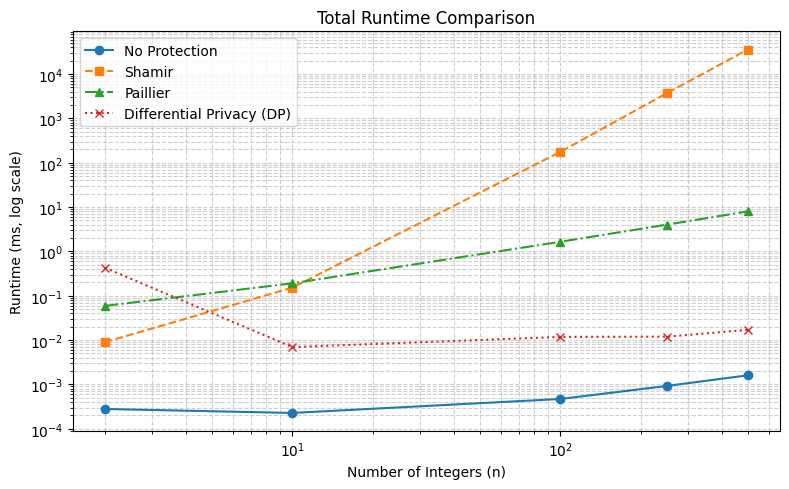

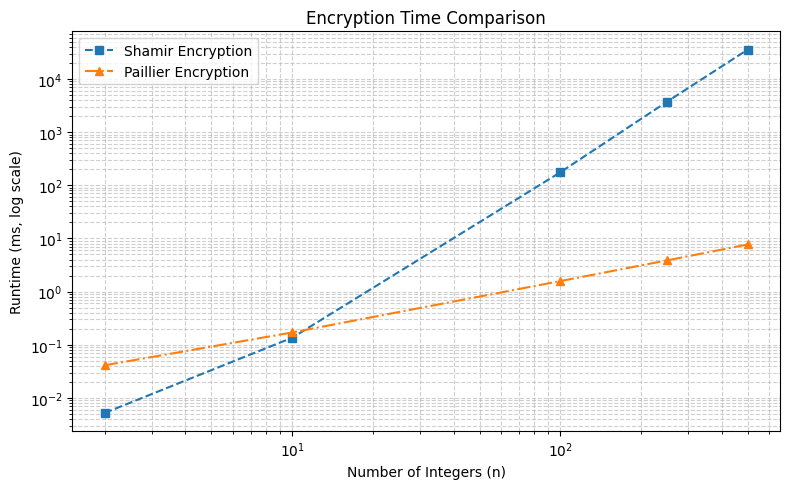

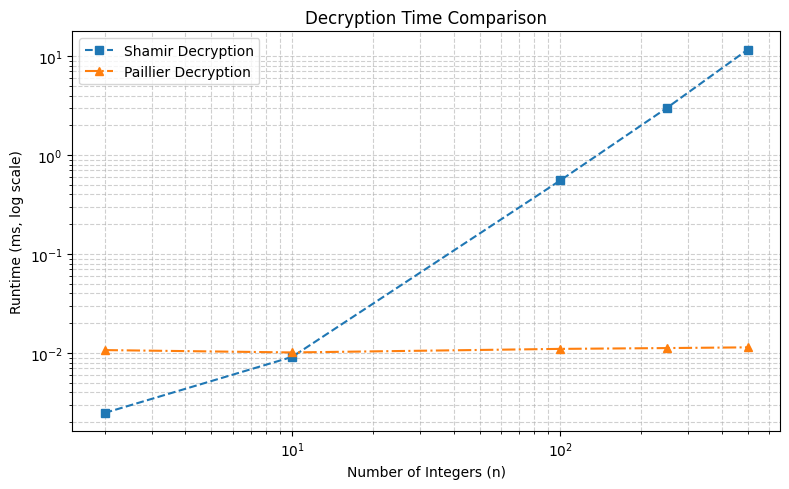

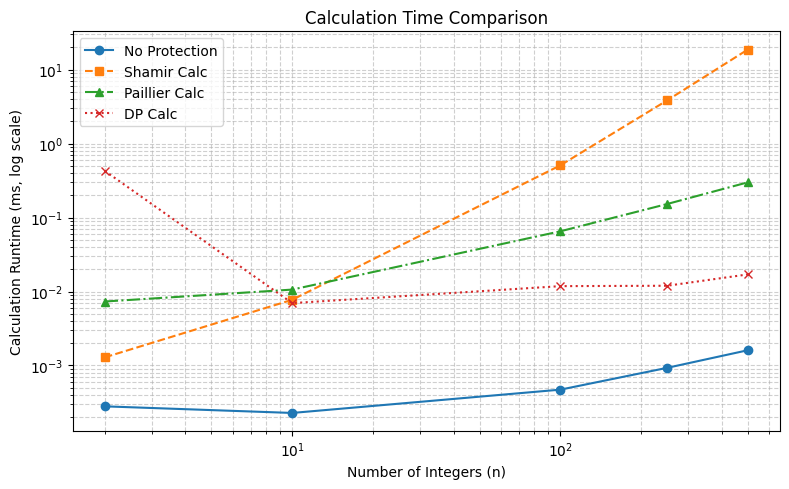

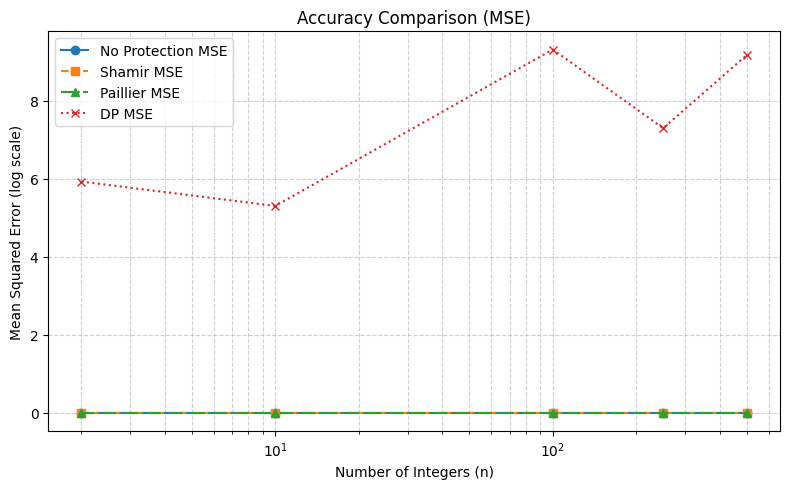

In [11]:
import matplotlib.pyplot as plt

# --- Convert times to ms ---
no_protection_ms = [rt * 1000 for rt in no_protection_runtimes]
shamir_total_ms = [(e+c+d) * 1000 for e, c, d in zip(shamir_enc_times, shamir_calc_times, shamir_dec_times)]
paillier_total_ms = [(e+a+d) * 1000 for e, a, d in zip(paillier_enc_times, paillier_add_times, paillier_dec_times)]
dp_total_ms = [rt * 1000 for rt in dp_times]

shamir_enc_ms = [t * 1000 for t in shamir_enc_times]
shamir_dec_ms = [t * 1000 for t in shamir_dec_times]
paillier_enc_ms = [t * 1000 for t in paillier_enc_times]
paillier_dec_ms = [t * 1000 for t in paillier_dec_times]

# Calculation times
calc_no_protection_ms = no_protection_ms
calc_shamir_ms = [t * 1000 for t in shamir_calc_times]
calc_paillier_ms = [t * 1000 for t in paillier_add_times]
calc_dp_ms = dp_total_ms   # DP has only one phase

# --- PLOT 1: TOTAL TIME ---
plt.figure(figsize=(8,5))
plt.plot(n_values, no_protection_ms, marker='o', label="No Protection")
plt.plot(n_values, shamir_total_ms, marker='s', linestyle='--', label="Shamir")
plt.plot(n_values, paillier_total_ms, marker='^', linestyle='-.', label="Paillier")
plt.plot(n_values, dp_total_ms, marker='x', linestyle=':', label="Differential Privacy (DP)")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Number of Integers (n)")
plt.ylabel("Runtime (ms, log scale)")
plt.title("Total Runtime Comparison")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plot_total_runtime.png", dpi=300)
plt.show()

# --- PLOT 2: ENCRYPTION TIME ---
plt.figure(figsize=(8,5))
plt.plot(n_values, shamir_enc_ms, marker='s', linestyle='--', label="Shamir Encryption")
plt.plot(n_values, paillier_enc_ms, marker='^', linestyle='-.', label="Paillier Encryption")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Number of Integers (n)")
plt.ylabel("Runtime (ms, log scale)")
plt.title("Encryption Time Comparison")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plot_encryption_time.png", dpi=300)
plt.show()

# --- PLOT 3: DECRYPTION TIME ---
plt.figure(figsize=(8,5))
plt.plot(n_values, shamir_dec_ms, marker='s', linestyle='--', label="Shamir Decryption")
plt.plot(n_values, paillier_dec_ms, marker='^', linestyle='-.', label="Paillier Decryption")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Number of Integers (n)")
plt.ylabel("Runtime (ms, log scale)")
plt.title("Decryption Time Comparison")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plot_decryption_time.png", dpi=300)
plt.show()

# --- PLOT 4: CALCULATION TIME ---
plt.figure(figsize=(8,5))
plt.plot(n_values, calc_no_protection_ms, marker='o', label="No Protection")
plt.plot(n_values, calc_shamir_ms, marker='s', linestyle='--', label="Shamir Calc")
plt.plot(n_values, calc_paillier_ms, marker='^', linestyle='-.', label="Paillier Calc")
plt.plot(n_values, calc_dp_ms, marker='x', linestyle=':', label="DP Calc")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Number of Integers (n)")
plt.ylabel("Calculation Runtime (ms, log scale)")
plt.title("Calculation Time Comparison")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plot_calculation_time.png", dpi=300)
plt.show()

# --- PLOT 5 : ACCURACY (MSE) COMPARISON ---
dp_mse_vals = [dp_accuracy[n] for n in n_values]
shamir_mse_vals = [shamir_accuracy[n] for n in n_values]
paillier_mse_vals = [paillier_accuracy[n] for n in n_values]
noprot_mse_vals = [no_protection_accuracy[n] for n in n_values]

plt.figure(figsize=(8,5))
plt.plot(n_values, noprot_mse_vals, marker='o', label="No Protection MSE")
plt.plot(n_values, shamir_mse_vals, marker='s', linestyle='--', label="Shamir MSE")
plt.plot(n_values, paillier_mse_vals, marker='^', linestyle='-.', label="Paillier MSE")
plt.plot(n_values, dp_mse_vals, marker='x', linestyle=':', label="DP MSE")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Number of Integers (n)")
plt.ylabel("Mean Squared Error (log scale)")
plt.title("Accuracy Comparison (MSE)")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plot_accuracy_mse.png", dpi=300)
plt.show()


In [12]:
import pandas as pd
import csv

# 1. Export Shamir timing breakdown
shamir_data = {
    'n': n_values,
    'encryption_time_ms': [t * 1000 for t in shamir_enc_times],
    'calculation_time_ms': [t * 1000 for t in shamir_calc_times],
    'decryption_time_ms': [t * 1000 for t in shamir_dec_times],
    'total_time_ms': [(enc + calc + dec) * 1000 for enc, calc, dec in 
                      zip(shamir_enc_times, shamir_calc_times, shamir_dec_times)],
    'result': [shamir_results[n] for n in n_values]
}
shamir_df = pd.DataFrame(shamir_data)
shamir_df.to_csv('shamir_results.csv', index=False)
print("Saved: shamir_results.csv")

# 2. Export Paillier timing breakdown
paillier_data = {
    'n': n_values,
    'encryption_time_ms': [t * 1000 for t in paillier_enc_times],
    'addition_time_ms': [t * 1000 for t in paillier_add_times],
    'decryption_time_ms': [t * 1000 for t in paillier_dec_times],
    'total_time_ms': [(enc + add + dec) * 1000 for enc, add, dec in 
                      zip(paillier_enc_times, paillier_add_times, paillier_dec_times)],
    'result': [paillier_results[n] for n in n_values]
}
paillier_df = pd.DataFrame(paillier_data)
paillier_df.to_csv('paillier_results.csv', index=False)
print("Saved: paillier_results.csv")

# 3. Export Differential Privacy timing breakdown
dp_data = {
    'n': n_values,
    'dp_time_ms': [t * 1000 for t in dp_times],
    'result': [dp_results[n] for n in n_values]
}
dp_df = pd.DataFrame(dp_data)
dp_df.to_csv('dp_results.csv', index=False)
print("Saved: dp_results.csv")

# 4. Export combined comparison (all methods)
comparison_data = {
    'n': n_values,
    'no_protection_time_ms': [t * 1000 for t in no_protection_runtimes],
    'shamir_total_time_ms': [(enc + calc + dec) * 1000 for enc, calc, dec in 
                             zip(shamir_enc_times, shamir_calc_times, shamir_dec_times)],
    'paillier_total_time_ms': [(enc + add + dec) * 1000 for enc, add, dec in 
                               zip(paillier_enc_times, paillier_add_times, paillier_dec_times)],
    'dp_time_ms': [t * 1000 for t in dp_times],
    'no_protection_result': [no_protection_results[n] for n in n_values],
    'shamir_result': [shamir_results[n] for n in n_values],
    'paillier_result': [paillier_results[n] for n in n_values],
    'dp_result': [dp_results[n] for n in n_values]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv('comparison_results.csv', index=False)
print("Saved: comparison_results.csv")

# 5. Export encryption comparison (Shamir vs Paillier only)
encryption_comparison = {
    'n': n_values,
    'shamir_encryption_ms': [t * 1000 for t in shamir_enc_times],
    'paillier_encryption_ms': [t * 1000 for t in paillier_enc_times]
}
encryption_df = pd.DataFrame(encryption_comparison)
encryption_df.to_csv('encryption_comparison.csv', index=False)
print("Saved: encryption_comparison.csv")

# 6. Export decryption comparison (Shamir vs Paillier only)
decryption_comparison = {
    'n': n_values,
    'shamir_decryption_ms': [t * 1000 for t in shamir_dec_times],
    'paillier_decryption_ms': [t * 1000 for t in paillier_dec_times]
}
decryption_df = pd.DataFrame(decryption_comparison)
decryption_df.to_csv('decryption_comparison.csv', index=False)
print("Saved: decryption_comparison.csv")

print("\nAll CSV files generated successfully!")

Saved: shamir_results.csv
Saved: paillier_results.csv
Saved: dp_results.csv
Saved: comparison_results.csv
Saved: encryption_comparison.csv
Saved: decryption_comparison.csv

All CSV files generated successfully!
